In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import time

try:
    from new_pytorch_dataset import train_loader, val_loader, test_loader, NUM_CLASSES, CLASSES
except ImportError:
    print("Error: Could not import 'new_pytorch_dataset'.")
    print("Make sure the file is in the same folder or its path is configured.")
    exit()

Setting up Datasets and DataLoaders...

Datasets and DataLoaders configured successfully.
Training set size: 24000 images
Validation set size: 500 images
Test set size: 500 images
Number of training batches: 750
Number of validation batches: 16
Number of test batches: 16


Using device: cuda
Starting training for 10 epochs...
Epoch 1/10


Validating: 100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:42<00:00,  2.66s/it]


  Training Loss: 0.3383, Training Accuracy: 0.8822
  Validation Loss: 0.2307, Validation Accuracy: 0.9340
  Epoch Time: 144.19 seconds

  -> Model saved: best validation accuracy 0.9340

Epoch 2/10


Validating: 100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:46<00:00,  2.89s/it]


  Training Loss: 0.1553, Training Accuracy: 0.9456
  Validation Loss: 0.1767, Validation Accuracy: 0.9540
  Epoch Time: 153.62 seconds

  -> Model saved: best validation accuracy 0.9540

Epoch 3/10


Validating: 100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:52<00:00,  3.30s/it]


  Training Loss: 0.0989, Training Accuracy: 0.9657
  Validation Loss: 0.1904, Validation Accuracy: 0.9480
  Epoch Time: 176.23 seconds

Epoch 4/10


Validating: 100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:53<00:00,  3.35s/it]


  Training Loss: 0.0721, Training Accuracy: 0.9755
  Validation Loss: 0.2271, Validation Accuracy: 0.9460
  Epoch Time: 196.32 seconds

Epoch 5/10


Validating: 100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:48<00:00,  3.04s/it]


  Training Loss: 0.0591, Training Accuracy: 0.9798
  Validation Loss: 0.2680, Validation Accuracy: 0.9360
  Epoch Time: 182.00 seconds

Epoch 6/10


Validating: 100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:48<00:00,  3.02s/it]


  Training Loss: 0.0465, Training Accuracy: 0.9849
  Validation Loss: 0.2065, Validation Accuracy: 0.9520
  Epoch Time: 178.62 seconds

Epoch 7/10


Validating: 100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:50<00:00,  3.18s/it]


  Training Loss: 0.0388, Training Accuracy: 0.9873
  Validation Loss: 0.1836, Validation Accuracy: 0.9460
  Epoch Time: 180.05 seconds

Epoch 8/10


Validating: 100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:49<00:00,  3.08s/it]


  Training Loss: 0.0353, Training Accuracy: 0.9879
  Validation Loss: 0.3579, Validation Accuracy: 0.9360
  Epoch Time: 180.30 seconds

Epoch 9/10


Validating: 100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:48<00:00,  3.03s/it]


  Training Loss: 0.0303, Training Accuracy: 0.9895
  Validation Loss: 0.2371, Validation Accuracy: 0.9480
  Epoch Time: 182.23 seconds

Epoch 10/10


Validating: 100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:49<00:00,  3.11s/it]


  Training Loss: 0.0262, Training Accuracy: 0.9912
  Validation Loss: 0.2267, Validation Accuracy: 0.9540
  Epoch Time: 186.09 seconds


Training finished.

--- Evaluating the best model on the test set ---


Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:45<00:00,  2.87s/it]



Accuracy on the test set: 0.9480
Precision (weighted): 0.9515
Recall (weighted): 0.9480
F1-Score (weighted): 0.9488


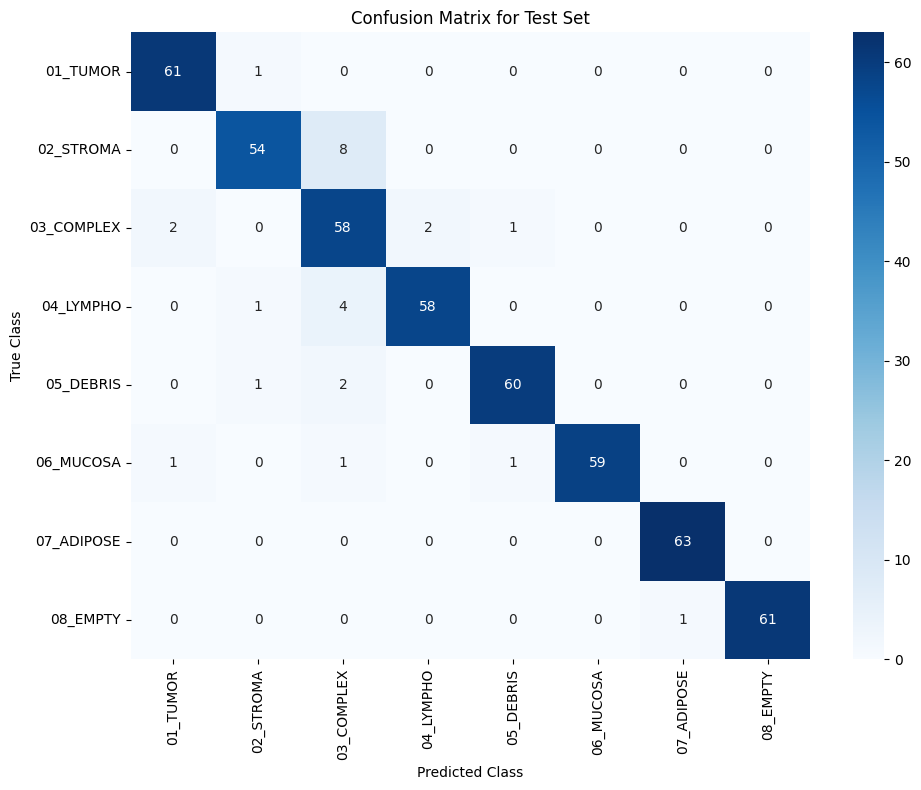

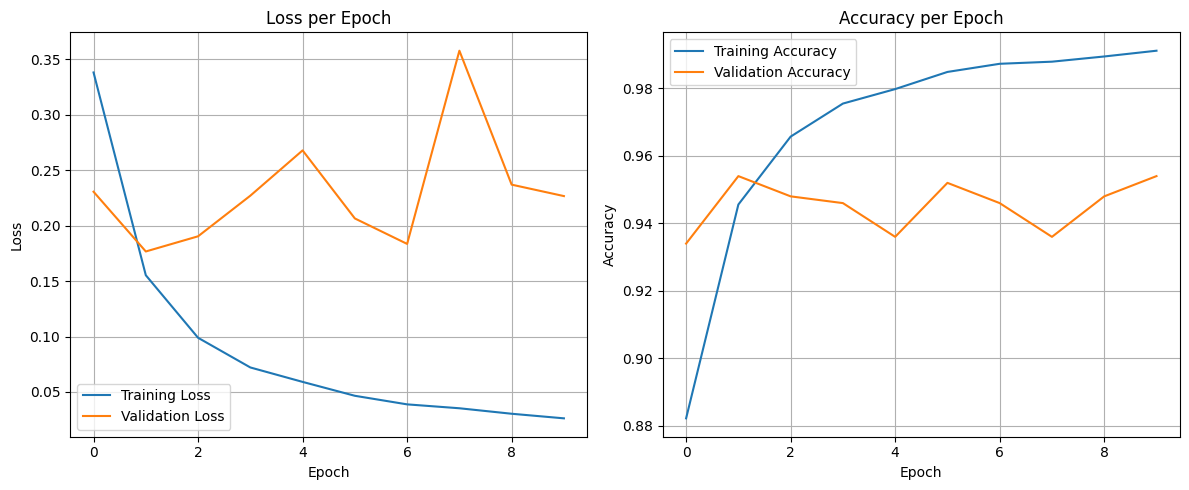


Results saved in: C:\Users\luism\Intelligent agents\Colorectar Cancer\resnet_results


In [2]:
# --- Training Configuration ---
LEARNING_RATE = 0.0001  # Adjusted for larger dataset
NUM_EPOCHS = 10  # Reduced due to larger dataset (24,000 images)
MODEL_OUTPUT_DIR = 'resnet_results'
os.makedirs(MODEL_OUTPUT_DIR, exist_ok=True)

# 1. Configure the device (GPU if available, otherwise CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 2. Load pre-trained ResNet50 and modify the final layer for your classification
model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)

# Unfreeze more layers for fine-tuning with larger dataset
for param in model.parameters():
    param.requires_grad = False
for param in model.layer4.parameters():  # Unfreeze layer4 for fine-tuning
    param.requires_grad = True

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, NUM_CLASSES)
model = model.to(device)

# 3. Define the Loss Function and the Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# 4. Training Loop
best_val_accuracy = 0.0
history = {'train_loss': [], 'val_loss': [], 'train_accuracy': [], 'val_accuracy': []}

print(f"Starting training for {NUM_EPOCHS} epochs...")
for epoch in range(NUM_EPOCHS):
    start_time = time.time()

    # --- Training Phase ---
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    print(f"Epoch {epoch+1}/{NUM_EPOCHS}")

    for images, labels in tqdm(train_loader, desc="Training"):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass: calculate model outputs
        outputs = model(images)
        # Calculate the loss
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        # Calculate predictions for training accuracy
        _, predicted = torch.max(outputs.data, 1)
        total_predictions += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

    epoch_train_loss = running_loss / len(train_loader.dataset)
    epoch_train_accuracy = correct_predictions / total_predictions
    history['train_loss'].append(epoch_train_loss)
    history['train_accuracy'].append(epoch_train_accuracy)

    # --- Validation Phase ---
    model.eval()
    val_running_loss = 0.0
    val_correct_predictions = 0
    val_total_predictions = 0
    all_val_preds = []
    all_val_labels = []

    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc="Validating"):
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            val_running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            val_total_predictions += labels.size(0)
            val_correct_predictions += (predicted == labels).sum().item()

            all_val_preds.extend(predicted.cpu().numpy())
            all_val_labels.extend(labels.cpu().numpy())

    epoch_val_loss = val_running_loss / len(val_loader.dataset)
    epoch_val_accuracy = val_correct_predictions / val_total_predictions
    history['val_loss'].append(epoch_val_loss)
    history['val_accuracy'].append(epoch_val_accuracy)

    end_time = time.time()
    epoch_time = end_time - start_time

    print(f"  Training Loss: {epoch_train_loss:.4f}, Training Accuracy: {epoch_train_accuracy:.4f}")
    print(f"  Validation Loss: {epoch_val_loss:.4f}, Validation Accuracy: {epoch_val_accuracy:.4f}")
    print(f"  Epoch Time: {epoch_time:.2f} seconds\n")

    # Save the best model based on validation accuracy
    if epoch_val_accuracy > best_val_accuracy:
        best_val_accuracy = epoch_val_accuracy
        torch.save(model.state_dict(), os.path.join(MODEL_OUTPUT_DIR, 'best_resnet50_model.pth'))
        print(f"  -> Model saved: best validation accuracy {best_val_accuracy:.4f}\n")

print("\nTraining finished.")

# --- 5. Evaluation ---
print("\n--- Evaluating the best model on the test set ---")

model.load_state_dict(torch.load(os.path.join(MODEL_OUTPUT_DIR, 'best_resnet50_model.pth')))
model.eval()

test_correct_predictions = 0
test_total_predictions = 0
all_test_preds = []
all_test_labels = []

with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Evaluating"):
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        test_total_predictions += labels.size(0)
        test_correct_predictions += (predicted == labels).sum().item()

        all_test_preds.extend(predicted.cpu().numpy())
        all_test_labels.extend(labels.cpu().numpy())

test_accuracy = test_correct_predictions / test_total_predictions
print(f"\nAccuracy on the test set: {test_accuracy:.4f}")

class_names_for_metrics = [CLASSES[i+1] for i in range(NUM_CLASSES)]

precision, recall, f1, _ = precision_recall_fscore_support(all_test_labels, all_test_preds, average='weighted', zero_division=0)
print(f"Precision (weighted): {precision:.4f}")
print(f"Recall (weighted): {recall:.4f}")
print(f"F1-Score (weighted): {f1:.4f}")

# --- Confusion Matrix ---
cm = confusion_matrix(all_test_labels, all_test_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names_for_metrics, yticklabels=class_names_for_metrics)
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.title("Confusion Matrix for Test Set")
plt.tight_layout()
plt.savefig(os.path.join(MODEL_OUTPUT_DIR, 'confusion_matrix.png'))
plt.show()

# --- Plotting Training History (Loss and Accuracy) ---
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history['train_accuracy'], label='Training Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig(os.path.join(MODEL_OUTPUT_DIR, 'training_history.png'))
plt.show()

print(f"\nResults saved in: {os.path.abspath(MODEL_OUTPUT_DIR)}")